## _*Bootstrapping next computation from prior result*_

This notebook demonstrates using QISKit ACQUA Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the ExactEigensolver and we also compare using the previous computed optimal solution as the starting initial point for the next distance.

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the Qiskit Acqua Chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYQUANTE chemistry driver. See the PYQUANTE chemistry driver readme if you need to install the external PyQuante2 library that this driver requires.

In [1]:
import paths
import numpy as np
import pylab
from qiskit_acqua_chemistry import ACQUAChemistry

# Input dictionary to configure QISKit ACQUA Chemistry for the chemistry problem.
acqua_chemistry_dict = {
    'problem': {'random_seed': 50},
    'driver': {'name': 'PYQUANTE'},
    'PYQUANTE': {'atoms': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': 'parity',
                 'two_qubit_reduction': True},
    'algorithm': {'name': ''},
    'optimizer': {'name': 'COBYLA', 'maxiter': 10000 },
    'variational_form': {'name': 'RYRZ', 'depth': '5', 'entanglement': 'linear'}
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
algorithms = [{'name': 'VQE'},
              {'name': 'VQE'},
              {'name': 'ExactEigensolver'}]
titles= ['VQE Random Seed', 'VQE + Initial Point', 'ExactEigensolver']

start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)
eval_counts = np.zeros([len(algorithms), steps+1], dtype=np.intp)

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps
    acqua_chemistry_dict['PYQUANTE']['atoms'] = molecule.format(d/2) 
    for j in range(len(algorithms)):
        acqua_chemistry_dict['algorithm'] = algorithms[j] 
        solver = ACQUAChemistry()
        result = solver.run(acqua_chemistry_dict)
        energies[j][i] = result['energy']
        hf_energies[i] = result['hf_energy']
        if algorithms[j]['name'] == 'VQE':
            eval_counts[j][i] = result['algorithm_retvals']['eval_count']
            if j == 1:
                algorithms[j]['initial_point'] = result['algorithm_retvals']['opt_params']
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)


Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[-1.05515974 -1.07591361 -1.09262987 -1.10591801 -1.11628598 -1.12416089
  -1.12990476 -1.1338262  -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.1315512  -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]
 [-1.05515974 -1.07591361 -1.09262987 -1.10591801 -1.11628599 -1.12416089
  -1.12990475 -1.1338262  -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.1315512  -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133942 -1.10634211 -1.10115033]
 [-1.05515974 -1.07591361 -1.09262987 -1.10591802 -1.11628599 -1.12416089
  -1.12990476 -1.1338262  -1.13618944 -1.13722136 -1.13711707 -1.13604436
  -1.13414767 -1.13155121 -1.12836188 -1.12467175 -1.12056028 -1.11609624
  -1.11133943 -1.10634212 -1.10115034]]
Hartree-Fock energies: [-1.042996

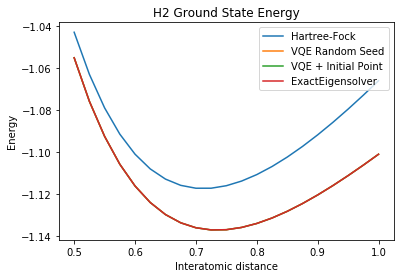

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=titles[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')

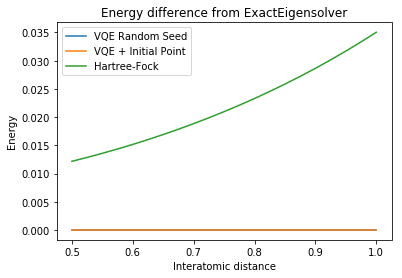

In [3]:
for i in range(2):
    pylab.plot(distances, np.subtract(energies[i], energies[2]), label=titles[i])
pylab.plot(distances, np.subtract(hf_energies, energies[2]), label='Hartree-Fock')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper left')

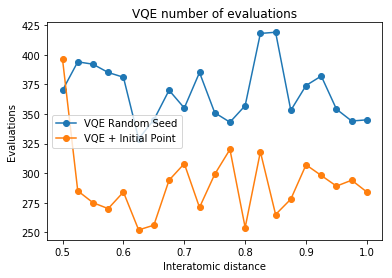

In [4]:
for i in range(2):
    pylab.plot(distances, eval_counts[i], '-o', label=titles[i])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='center left')